Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Total number of frames:  12356


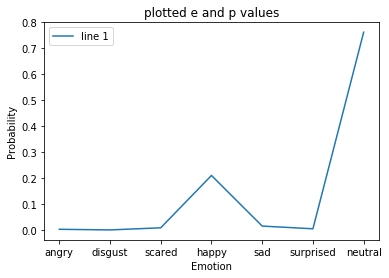

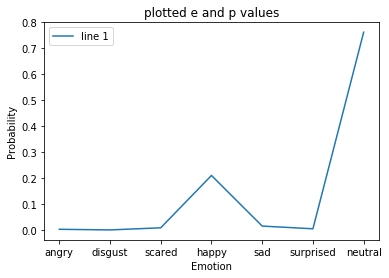

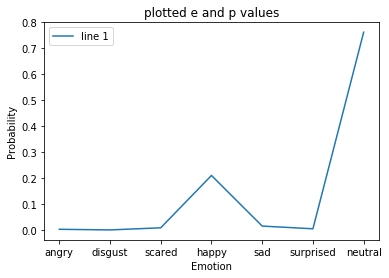

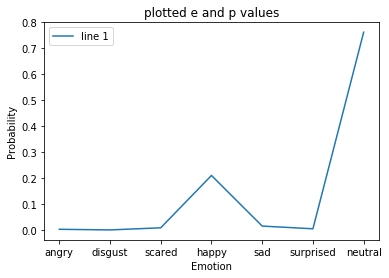

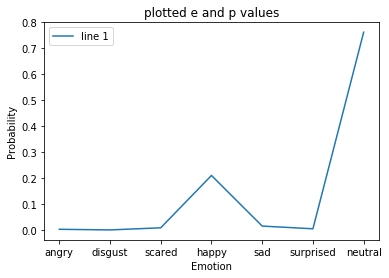

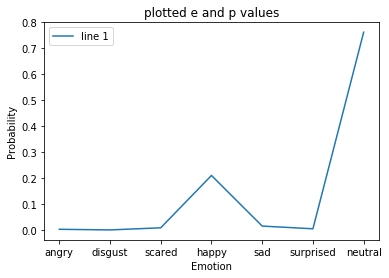

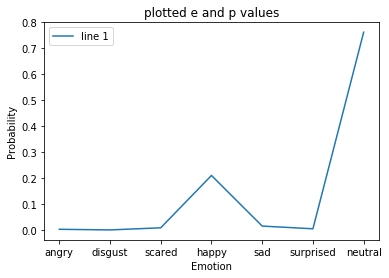

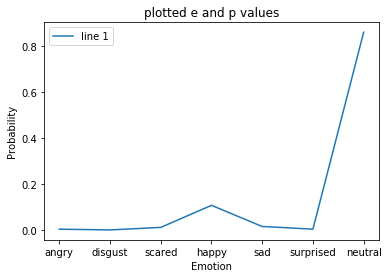

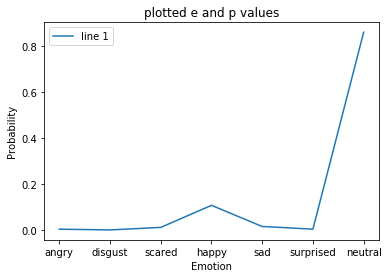

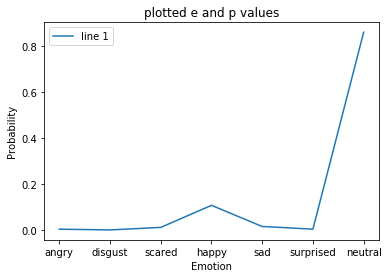

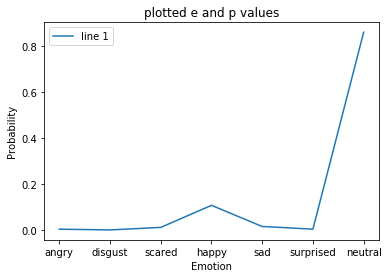

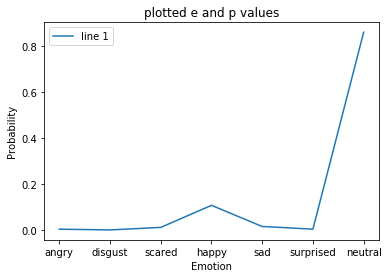

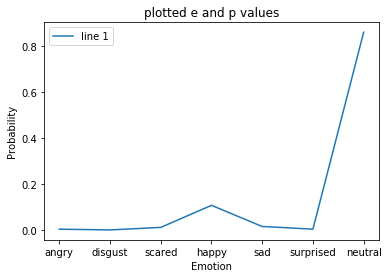

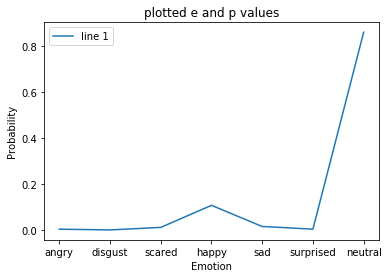

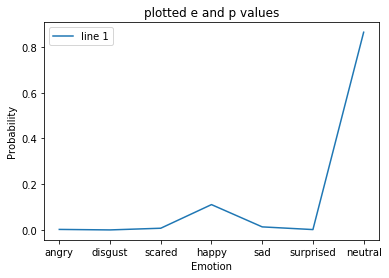

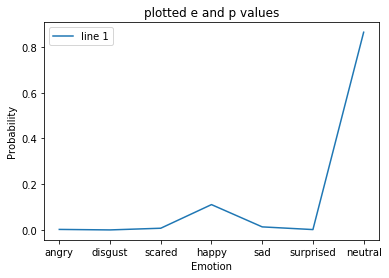

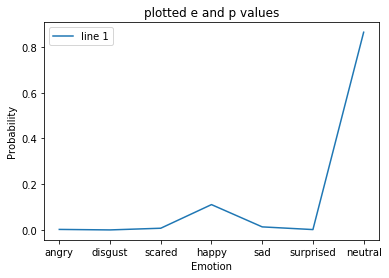

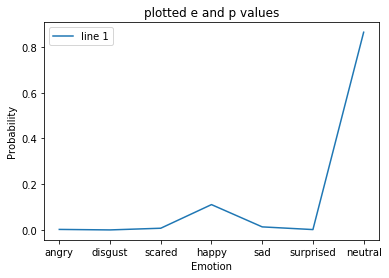

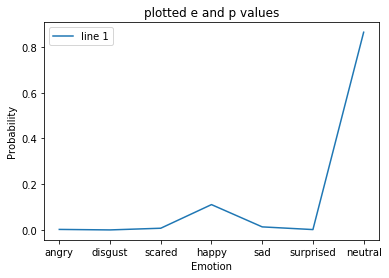

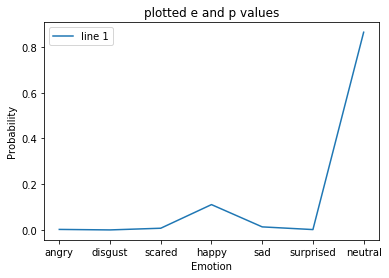

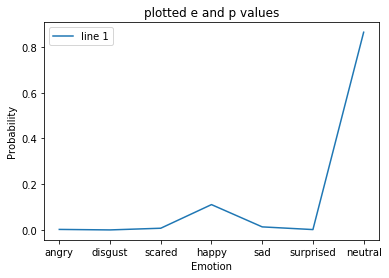

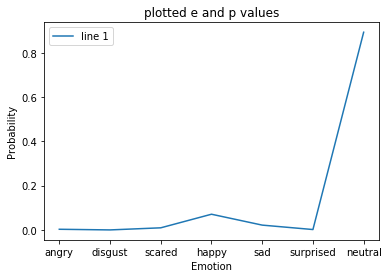

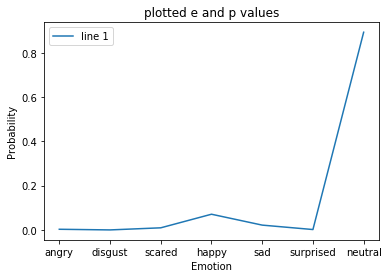

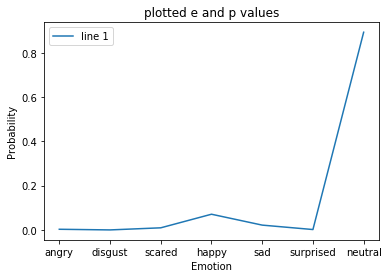

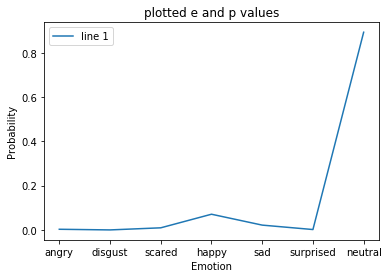

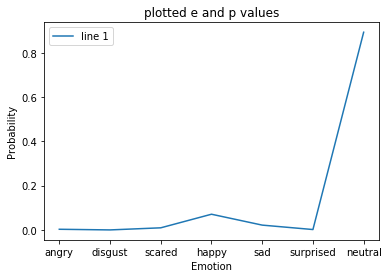

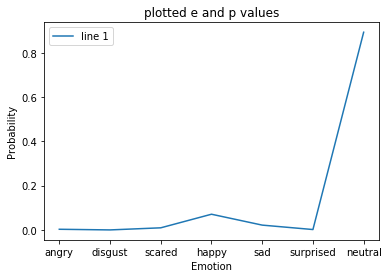

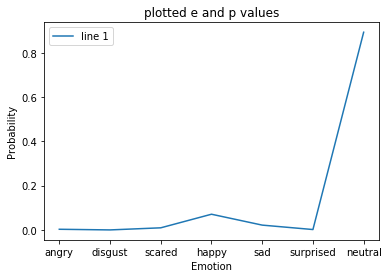

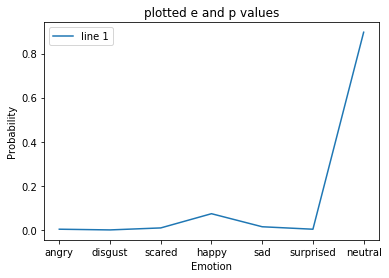

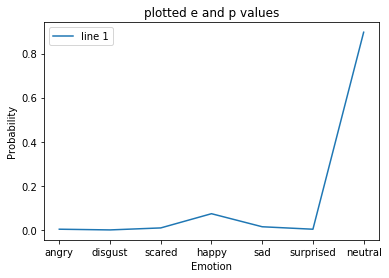

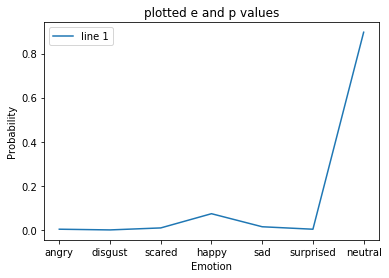

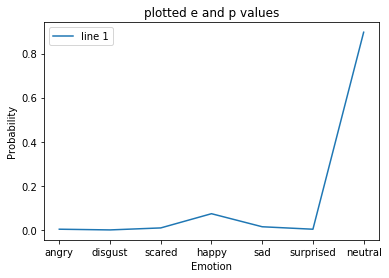

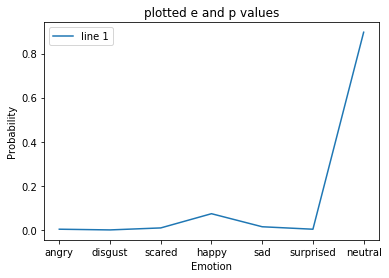

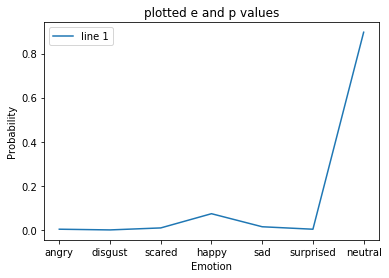

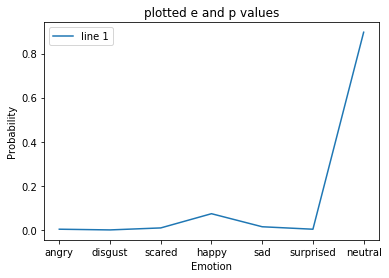

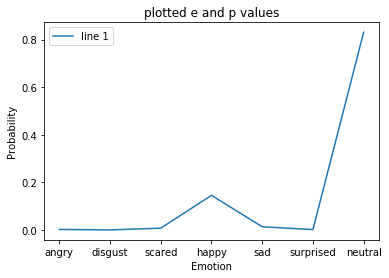

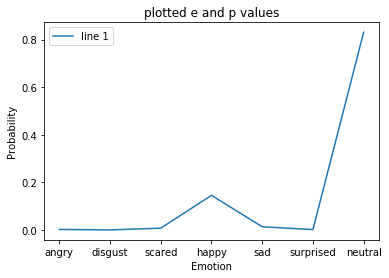

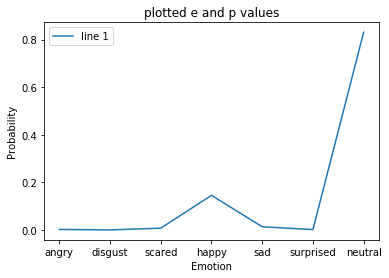

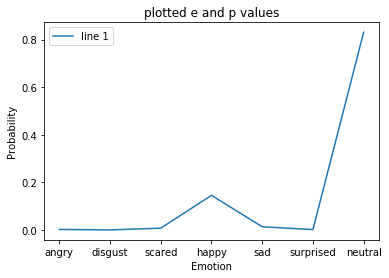

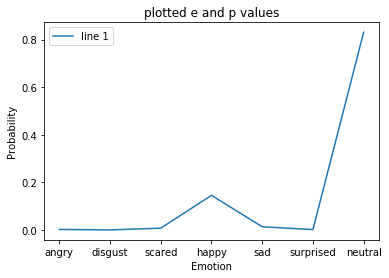

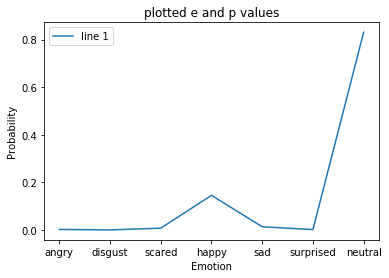

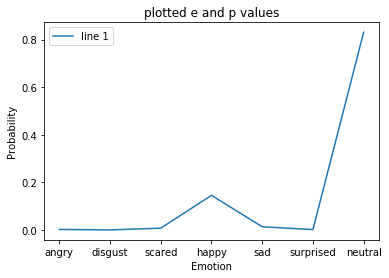

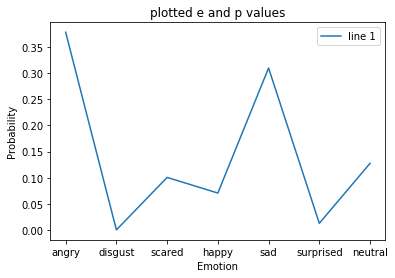

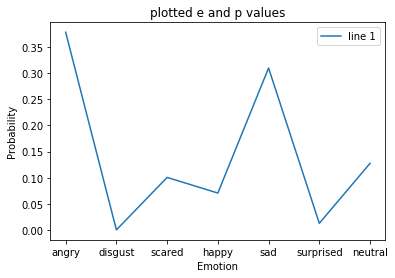

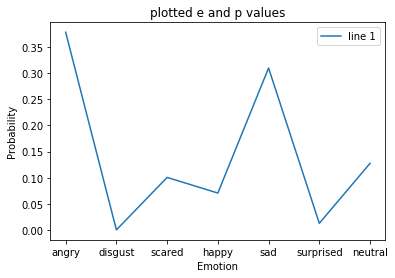

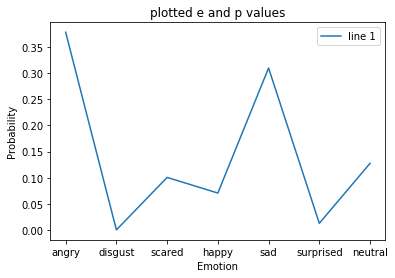

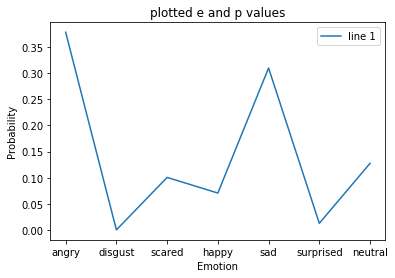

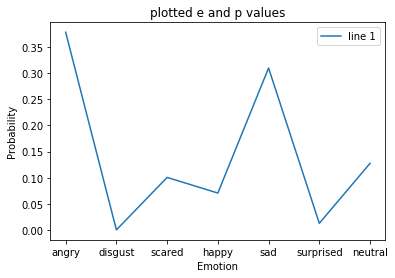

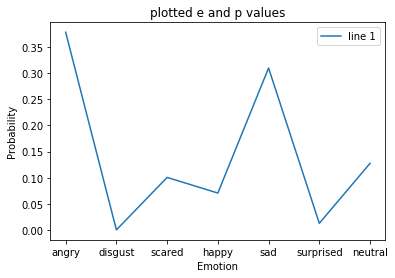

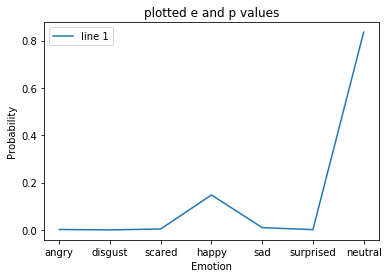

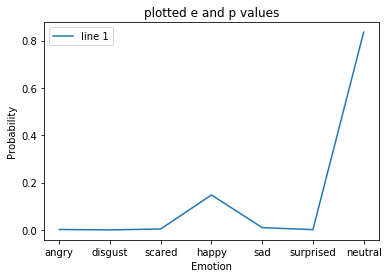

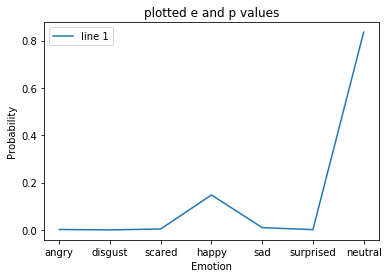

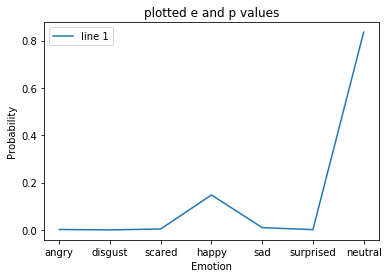

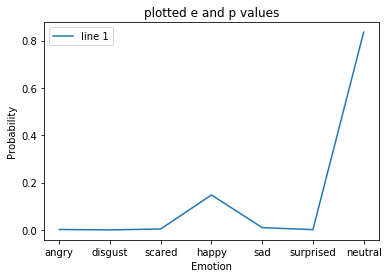

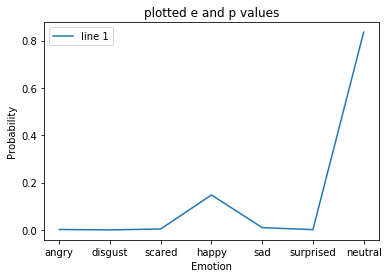

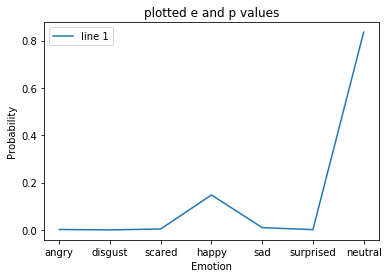

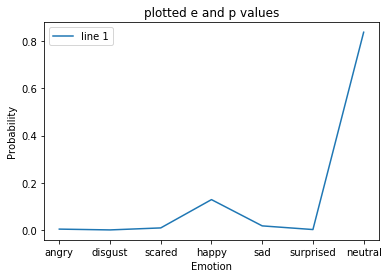

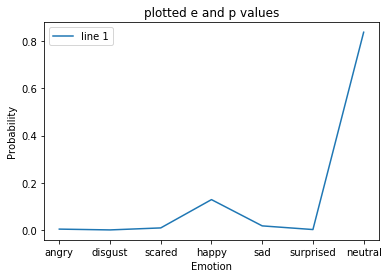

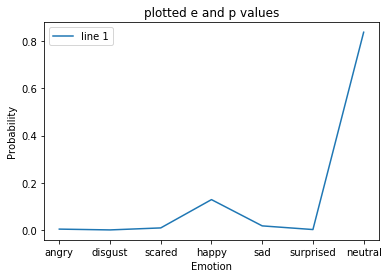

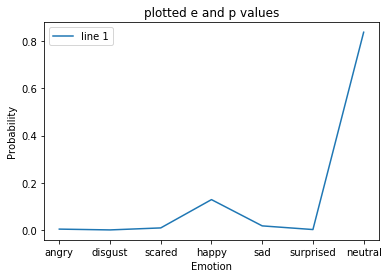

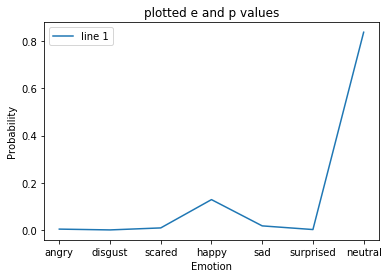

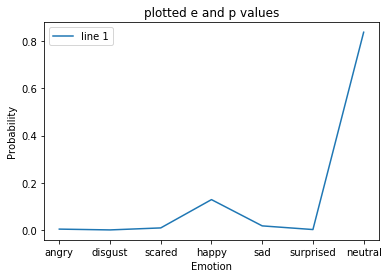

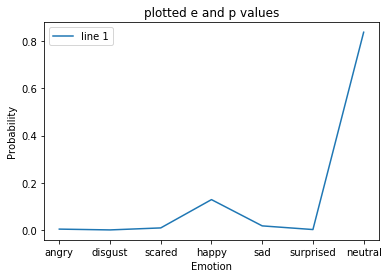

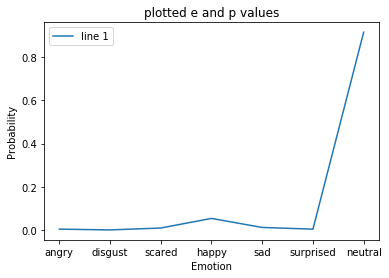

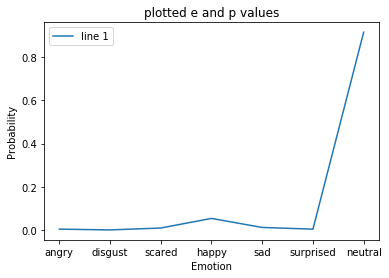

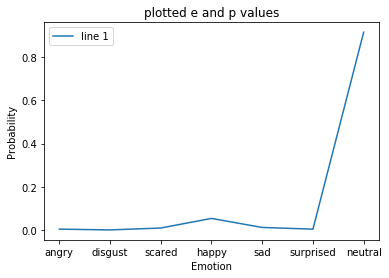

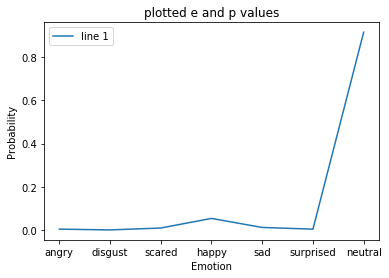

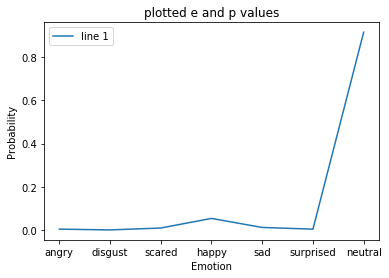

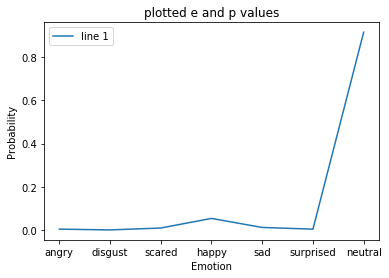

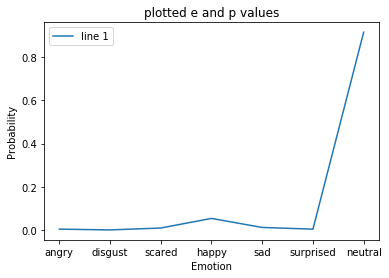

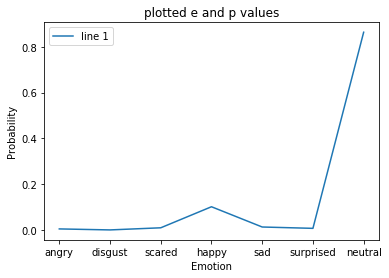

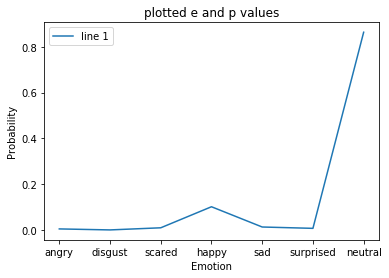

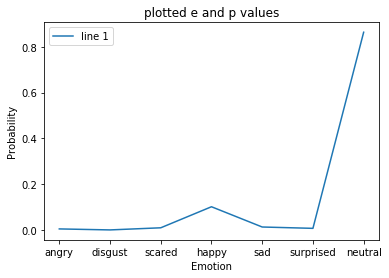

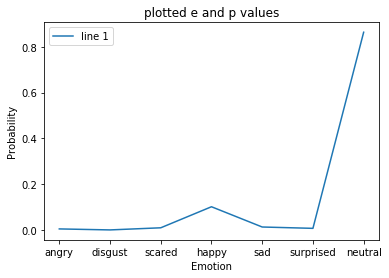

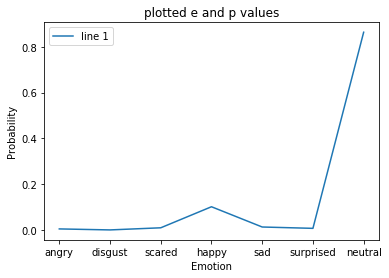

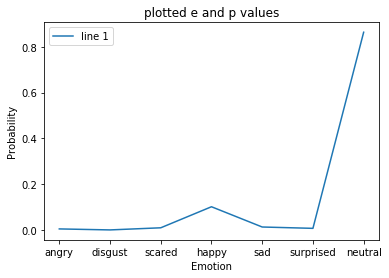

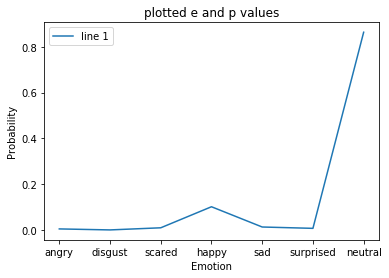

In [1]:
from keras.preprocessing.image import img_to_array
import imutils
import cv2
from keras.models import load_model
import numpy as np
import pafy 
import matplotlib.pyplot as plt
%matplotlib inline



# parameters for loading data and images
detection_model_path = '/Users/Aveen Faheem/Desktop/Anaconda_work/haarcascade_frontalface_default.xml'
emotion_model_path = '/Users/Aveen Faheem/Desktop/Anaconda_work/_mini_XCEPTION.106-0.65.hdf5'

# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)

emotion_classifier = load_model(emotion_model_path, compile=False)

EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised",
 "neutral"]


#Get a video URL from YouTube
url = 'https://www.youtube.com/watch?v=O6zneRsqOXI'
vPafy = pafy.new(url)
play = vPafy.getbest(preftype="mp4")


# starting video streaming
#cv2.namedWindow('your_face')
camera = cv2.VideoCapture(play.url)

length = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
print('Total number of frames: ', length )

while True:
    frame = camera.read()[1]
    #reading the frame
    frame = imutils.resize(frame,width=900)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detection.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
    
    canvas = np.zeros((250, 300, 3), dtype="uint8")
    frameClone = frame.copy()
    if len(faces) > 0:
        faces = sorted(faces, reverse=True,
        key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
        (fX, fY, fW, fH) = faces
        # Extract the ROI of the face from the grayscale image, resize it to a fixed 48x48 pixels, and then prepare
        # the ROI for classification via the CNN
        roi = gray[fY:fY + fH, fX:fX + fW]
        roi = cv2.resize(roi, (48, 48))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        
        
        preds = emotion_classifier.predict(roi)[0]
        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]

 
        for (i, (emotion, prob)) in enumerate(zip(EMOTIONS, preds)):
                    # construct the label text
                    text = "{}: {:.2f}%".format(emotion, prob * 100)
                    w = int(prob * 300)
                    cv2.rectangle(canvas, (7, (i * 35) + 5),
                    (w, (i * 35) + 35), (0, 0, 255), -1)
                    cv2.putText(canvas, text, (10, (i * 35) + 23),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45,
                    (255, 255, 255), 2)
                    cv2.putText(frameClone, label, (fX, fY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
                    cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH),
                                  (0, 0, 255), 2)
                    plt.plot(EMOTIONS,preds)
                    plt.xlabel('Emotion')
                    plt.ylabel('Probability')
                    plt.title('plotted e and p values')
                    plt.legend(['line 1'])

                    # save the figure
                    plt.savefig('ploting.png', dpi=300, bbox_inches='tight')


                    plt.show()

    cv2.imshow('Face', frameClone)
    cv2.imshow("Probabilities", canvas)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

camera.release()
cv2.destroyAllWindows()